# Semi-supervised anomaly detection: log mel-spectrogram - model 2

This notebook will show to implement in Tensorflow the AE model described in the paper [MIMII Dataset: Sound Dataset for
Malfunctioning Industrial Machine Investigation and Inspection](https://www.arxiv-vanity.com/papers/1909.09347/)

## Libraries

Let's load the libraries for this notebook.
- **Tensorflow dataset** to load the dataset
- **Tensorflow** to create an AE model
- **Pandas** to manipulate results
- **Sklearn** to compute metrics
- **Plotnine** to plot results

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    InputLayer,
    Dense,
)

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    roc_auc_score
)

import plotnine as p9

import datetime

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Sklearn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Plotnine: {p9.__version__}")

Tensorflow datasets: 4.2.0
Tensorflow: 2.4.1
Sklearn: 0.24.2
Numpy: 1.19.5
Pandas: 1.2.4
Plotnine: 0.8.0


Let's set the seed for the Tensorflow dataset.

In [3]:
config = tfds.ReadConfig(try_autocache=True, shuffle_seed=42)

## Dataset

Let's load the dataset and create three sets (train, validation, test). We make the train set (90%) and validation set (10%) from the train data and the test set from the test data. 

In [4]:
import pump
data_dir = "../dataset"

(train, val, test), info = tfds.load(
    "pump",
    split=["train[:90%]", "train[90%:]", "test"],
    data_dir=data_dir,
    with_info=True,
    shuffle_files=True,
    read_config=config,
)

## Feature extraction

We will use 64 log mel-band energies from a spectrogram with an analysis frame of 64 ms and 50% hop size. 

In [5]:
A = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=64, num_spectrogram_bins=512+1, sample_rate=16_000, dtype=tf.float32
)

In [6]:
def mel(item):
    audio = tf.cast(item["audio"], tf.float32)
    audio = audio / 2**15

    # Calculate the STFT of the audio signal
    stfts = tf.signal.stft(
            audio,
            frame_length=1024,
            frame_step=512,
            pad_end=False,  # librosa test compatibility
        )
    # Get Magnitude fo the STFT
    mag_stfts = tf.abs(stfts)

    # Get the mel-spectrogram
    melgrams = tf.tensordot(
            tf.square(mag_stfts), A, axes=1
    )

    # Change of base for logarithmics: from natural logarithmic to common logarithmic 
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator

    # Calculate the log-mel spectrogram    
    log_melgrams = 20 / 2 * _tf_log10(melgrams + 10e-6)

    # Concat 5 time frames together to feed the model
    concat_melgrams = tf.concat(
        [
            tf.roll(log_melgrams, shift=1, axis=0),
            tf.roll(log_melgrams, shift=2, axis=0),
            log_melgrams,
            tf.roll(log_melgrams, shift=-1, axis=0),
            tf.roll(log_melgrams, shift=-2, axis=0)
        ],
        axis=1,
    )
    concat_melgrams = concat_melgrams[2:-2,:]

    item["audio"] = concat_melgrams
    return item

Let's prepare the sets for training. AE models need that the input and the output be the same.

In [7]:
def prep_train(item):
    return item["audio"], item["audio"]

In [8]:
BATCH_SIZE = 512
SHUFFLE_BUFFER_SIZE = 1024

train = train.map(mel)
train2 = train.map(prep_train).batch(BATCH_SIZE)

val = train.map(mel)
val2 = train.map(prep_train).batch(BATCH_SIZE)

test = test.map(mel)
test2 = test.batch(BATCH_SIZE)

## Training

This is the AE model described in the paper [MIMII Dataset: Sound Dataset for
Malfunctioning Industrial Machine Investigation and Inspection](https://www.arxiv-vanity.com/papers/1909.09347/)

In [9]:
autoencoder = Sequential(
    [
        InputLayer(input_shape=(307, 320)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(320, activation=None)
    ]
)

In [10]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 307, 64)           20544     
_________________________________________________________________
dense_1 (Dense)              (None, 307, 64)           4160      
_________________________________________________________________
dense_2 (Dense)              (None, 307, 8)            520       
_________________________________________________________________
dense_3 (Dense)              (None, 307, 64)           576       
_________________________________________________________________
dense_4 (Dense)              (None, 307, 64)           4160      
_________________________________________________________________
dense_5 (Dense)              (None, 307, 320)          20800     
Total params: 50,760
Trainable params: 50,760
Non-trainable params: 0
____________________________________________________

We use same parameters as the paper.

In [11]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

Let's create a Tensorboard callback to check the results in Tensorboard and a ModelCheckpoint callback to save the best model.

In [12]:
log_dir = os.path.join('..', 'logs', 'semi-mel2', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir, update_freq=1, histogram_freq=1, write_graph=True
)

In [13]:
checkpoint_filepath = os.path.join("tmp", "semi-mel2", "checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [14]:
history = autoencoder.fit(
    train2,
    epochs=50,
    shuffle=True,
    validation_data=val2,
    callbacks=[tb_callback, model_checkpoint_callback],
    verbose=1,
)

Epoch 1/50
6/6 [==============================] - 55s 10s/step - loss: 130.8504 - val_loss: 117.5570
Epoch 2/50
6/6 [==============================] - 52s 10s/step - loss: 110.3534 - val_loss: 83.9491
Epoch 3/50
6/6 [==============================] - 52s 10s/step - loss: 75.7216 - val_loss: 51.0405
Epoch 4/50
6/6 [==============================] - 49s 9s/step - loss: 45.5870 - val_loss: 31.4599
Epoch 5/50
6/6 [==============================] - 50s 9s/step - loss: 28.9180 - val_loss: 22.7894
Epoch 6/50
6/6 [==============================] - 51s 9s/step - loss: 21.6699 - val_loss: 19.1685
Epoch 7/50
6/6 [==============================] - 51s 9s/step - loss: 18.6551 - val_loss: 17.7824
Epoch 8/50
6/6 [==============================] - 53s 10s/step - loss: 17.7109 - val_loss: 17.2379
Epoch 9/50
6/6 [==============================] - 53s 10s/step - loss: 17.0269 - val_loss: 16.9567
Epoch 10/50
6/6 [==============================] - 53s 10s/step - loss: 16.7412 - val_loss: 16.7900
Epoch 11/5

## Testing

Let's join train and test set together for faster predictions.

In [15]:
audios = train.concatenate(test)

In [16]:
pred = autoencoder.predict(audios.map(lambda item: item["audio"]).batch(BATCH_SIZE))

Let's compute the reconstruction error for all audios.

In [17]:
error_lst = []
for item, pred in zip(tfds.as_numpy(audios), pred):
    error = np.mean(np.square(item["audio"] - pred))
    error_lst.append(error)

To check how the model behaves, we can tranform the Tensorflow dataset into a dataframe and add the previous computed reconstruction error to it.

In [18]:
audios_df = tfds.as_dataframe(audios, info)

# Convert byte-type texts to string-type texts
for col in audios_df:
    if isinstance(audios_df[col][0], bytes):
        audios_df[col] = audios_df[col].str.decode("utf8")

dct_columns = {
    "audio/id": "id", 
    "audio/machine": "machine_id", 
    "audio/split": "split",
}

# Convert object-type columns to a more convenient data type
dct_types = {
    "id": "string",
    "machine_id": "category",
    "split": "category",
    "label": "category",
}

audios_df = (
    audios_df
    .rename(columns=dct_columns)
    .astype(dct_types)
)

audios_df.sample(5)

,audio,id,machine_id,split,label
1570,"[[-3.556941, -10.046806, -4.0233784, -5.850686...",0449,02,0,0
256,"[[-12.229973, -3.1116858, 0.78803945, -4.23137...",0429,04,0,0
3023,"[[-15.540577, -8.640378, -9.688185, -9.342045,...",0098,00,1,0
147,"[[5.5389814, 2.9668143, -2.8833034, -0.7131963...",0724,00,0,0
1167,"[[-14.932514, -6.6957703, 0.5308838, 2.7300396...",0887,00,0,0


In [19]:
audios_df["error"] = error_lst

In [20]:
audios_df.sample(5)

,audio,id,machine_id,split,label,error
8,"[[-2.5934253, -5.8448534, -0.25472486, 0.96838...",0591,02,0,0,22.324446
1464,"[[-1.1289089, 1.7798036, -1.743696, -4.5153446...",0871,02,0,0,35.472057
3133,"[[-1.0600116, 1.8603239, -2.8747277, -6.047671...",0014,00,1,0,27.988899
1350,"[[-4.1860347, -5.824897, -18.068216, -15.29117...",0550,04,0,0,33.881165
1619,"[[-4.97328, -2.1126065, -4.842038, -3.5150242,...",0473,02,0,0,23.904062


Let's compute the mean and the standard deviation of the reconstruction error of the train set.

In [21]:
(
    audios_df
    .query("split == 0")
    .groupby("machine_id")
    .agg({"error": ["mean", "std"]})
)

error           
                 mean        std
machine_id                      
00          27.281505  14.076459
02          27.978354  15.447013
04          26.869280  14.283533
06          27.203599  15.052430

Let's compute the mean and the standard deviation of the reconstruction error of the test set.

In [22]:
(
    audios_df
    .query("split == 1")
    .groupby(["label", "machine_id"])
    .agg({"error": ["mean", "std"]})
)

error           
                       mean        std
label machine_id                      
0     00          35.308341  22.540344
      02          32.098102  16.751448
      04          33.179823  15.316982
      06          36.700430  23.950227
1     00          37.809625  23.451231
      02          36.213753  25.061969
      04          33.083227  19.246610
      06          32.267794  16.443709

It seems this model can't distinguish anomaly sound from normal sounds very well.

Let's plot the a histogram of the construction error per machine to see more clear.

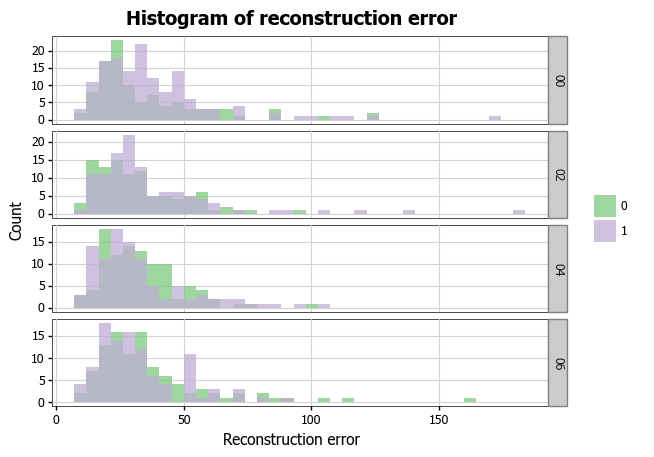

In [23]:
p = (
    p9.ggplot(audios_df.query("split == 1"), p9.aes(x="error", fill="label"))
    + p9.geom_histogram(
        p9.aes(y="stat(count)"), position="identity", alpha=0.75
    )
    + p9.scale_x_continuous(name="Reconstruction error")
    + p9.scale_y_continuous(name="Count")
    + p9.labs(
        title="Histogram of reconstruction error",
    )
    + p9.scale_fill_brewer(type="qualitative", palette="Accent") 
    + p9.facet_grid("machine_id ~ .", scales="free")
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_rect(colour="black", fill=None, size=0.5),
        axis_text_x=p9.element_text(colour="black", size=9),
        axis_text_y=p9.element_text(colour="black", size=9),
        legend_key=p9.element_blank(),
        legend_title=p9.element_blank(),
        panel_grid_major=p9.element_line(colour="#d3d3d3"),
        panel_grid_minor=p9.element_blank(),
        panel_background=p9.element_blank(),
        plot_title=p9.element_text(size=14, family="Tahoma", face="bold"),
        text=p9.element_text(family="Tahoma"),
    )
)

print(p)

Histograms show more clear that the model can't differentiate anomaly audios from normal audio very well.

This [AWS](https://aws.amazon.com/es/blogs/machine-learning/performing-anomaly-detection-on-industrial-equipment-using-audio-signals/) post shows how the histogram from a good model should look like.

![Better model](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2020/12/22/ML-1479-4.jpg)

## Metrics

Let's see how bad our model is. To distinguish anomaly audios from normal audios, we set the threshold one standard deviation above the mean of the train set. 

In [24]:
avg = (
    audios_df
    .query("split == 0")
    ["error"]
    .mean()
)

std = (
    audios_df
    .query("split == 0")
    ["error"]
    .std()
)

threshold = avg + std

In [25]:
print(threshold)

42.13697157438229


Let's create a new column with the predicted label based on the threshold.

In [26]:
audios_df["label_pred"] = audios_df["error"] > threshold

In [27]:
audios_df.head()

,audio,id,machine_id,split,label,error,label_pred
0,"[[4.3435826, -1.4703677, -6.8795943, -5.232863...",0784,06,0,0,20.133316,False
1,"[[-4.171905, -7.304402, -6.1516943, -0.3673963...",0215,02,0,0,67.171089,True
2,"[[-3.672999, -4.516965, 1.8487122, 1.7680111, ...",0918,06,0,0,17.989687,False
3,"[[-1.0986718, -0.51198477, 1.760179, -8.916344...",0033,06,0,0,23.110121,False
4,"[[-4.7961698, 1.6355705, -0.73018026, -3.11030...",0580,02,0,0,28.541954,False


Let's show the precision, recall, f1-score and roc-auc score for the four machines.

### Machine_id=00

In [28]:
machine_id = "00"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.43      0.74      0.54       100
           1       0.63      0.31      0.42       143

    accuracy                           0.49       243
   macro avg       0.53      0.53      0.48       243
weighted avg       0.55      0.49      0.47       243



In [29]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[74 26]
 [98 45]]


In [30]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5273


This model is slightly better distinguishing sounds for this machine that tossing a coin. 

### Machine_id=02

In [31]:
machine_id = "02"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.48      0.75      0.58       100
           1       0.54      0.26      0.35       111

    accuracy                           0.49       211
   macro avg       0.51      0.51      0.47       211
weighted avg       0.51      0.49      0.46       211



In [32]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[75 25]
 [82 29]]


In [33]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5056


This model is slightly better distinguishing sounds for this machine that tossing a coin. 

### Machine_id=04

In [34]:
machine_id = "04"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.50      0.76      0.60       100
           1       0.49      0.23      0.31       100

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.46       200
weighted avg       0.49      0.49      0.46       200



In [35]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[76 24]
 [77 23]]


In [36]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4950


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

### Machine_id=06

In [37]:
machine_id = "06"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.49      0.75      0.59       100
           1       0.48      0.23      0.31       102

    accuracy                           0.49       202
   macro avg       0.48      0.49      0.45       202
weighted avg       0.48      0.49      0.45       202



In [38]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[75 25]
 [79 23]]


In [39]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4877


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

## Conclusions

Although we tried to copy the model of the paper, metrics are worse.